<a href="https://colab.research.google.com/github/Nourin-Nusrat/CSE4261_DNN/blob/main/DNN_Assignment6_IG_GRAD_CAM_Considering_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library Import


In [1]:
import matplotlib.pylab as plt
import math

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras.applications.resnet_v2 import decode_predictions




#Model

In [2]:
model = tf.keras.applications.ResNet50V2(
    include_top=True,      # include the final classification layer
    weights='imagenet',    # pretrained on ImageNet
    input_shape=(224, 224, 3)
)
model.trainable = False
# model.summary()

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Load Images

3954129/3954129 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16117/16117 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
20398/20398 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16921/16921 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


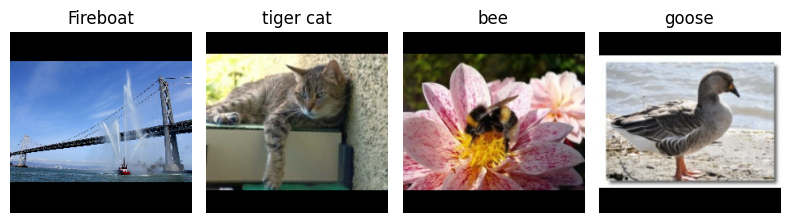

In [4]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'tiger cat': 'https://storage.googleapis.com/cvstock-932a9.appspot.com/thumbnail-TMB94WRFIQA6',
    'bee': 'https://storage.googleapis.com/cvstock-932a9.appspot.com/thumbnail-8H0XE95QIJLM',
    'goose': 'https://storage.googleapis.com/cvstock-932a9.appspot.com/thumbnail-VDJG98H1M7WX',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}
#plot
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 4, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [5]:
def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)

    # Scale to 0-255 if max <=1.0
    if tf.reduce_max(image) <= 1.0:
        image = image * 255.0

    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image

#Display Images with class prediction

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


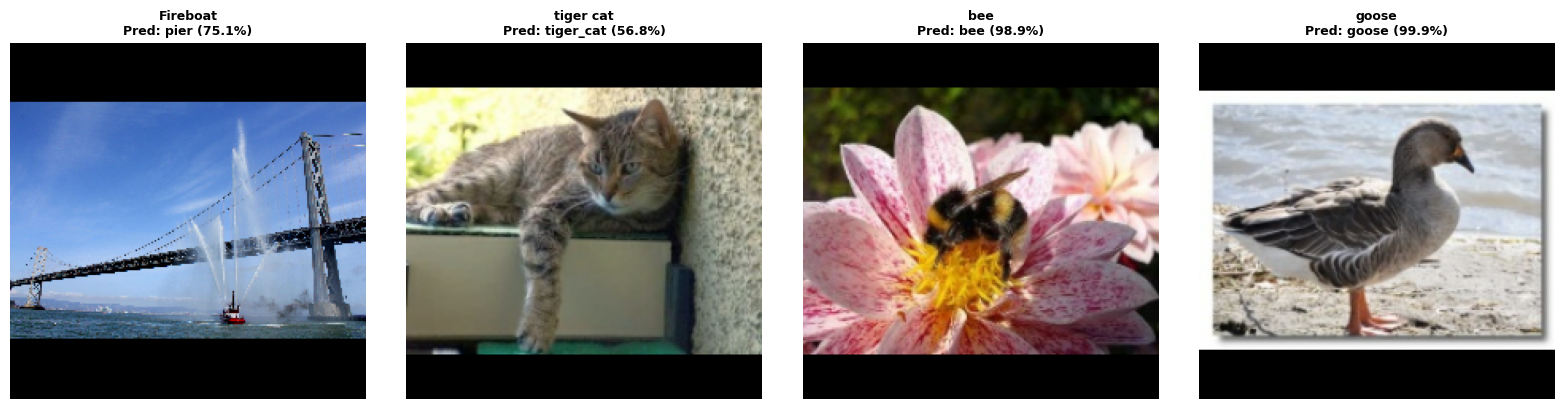

In [6]:
def display_image_grid_with_predictions(img_name_tensors, pretrained_model):
    total_images = len(img_name_tensors)
    cols = 4
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for ax, (name, img_tensor) in zip(axes, img_name_tensors.items()):
        img = preprocess(img_tensor)
        img_batch = tf.expand_dims(img, 0)
        preds = pretrained_model.predict(img_batch, verbose=0)
        _, pred_label, confidence = tf.keras.applications.resnet_v2.decode_predictions(preds, top=1)[0][0]

        # Show original image (assuming uint8 or float [0,1])
        if tf.is_tensor(img_tensor):
            img_to_show = img_tensor.numpy()
        else:
            img_to_show = img_tensor

        # If float and max <=1, scale for display
        if img_to_show.dtype != "uint8":
            if img_to_show.max() <= 1.0:
                img_to_show = (img_to_show * 255).astype("uint8")

        ax.imshow(img_to_show)
        ax.set_title(f"{name}\nPred: {pred_label} ({confidence:.1%})", fontweight='bold', fontsize=9)
        ax.axis('off')

    for i in range(len(img_name_tensors), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
display_image_grid_with_predictions(img_name_tensors, model)

#Baseline

In [7]:
baseline = tf.zeros(shape=(224,224,3))
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

#Interpolation

In [16]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

#Considering Softmax in IG

In [8]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)  # raw logits, no softmax
    target_logit = logits[:, target_class_idx]  # pick logit of target class directly
  return tape.gradient(target_logit, images)

In [9]:
def integral_approximation(gradients):
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

#Integrated Gradients

In [10]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
  gradient_batches = []
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
  total_gradients = tf.concat(gradient_batches, axis=0)
  avg_gradients = integral_approximation(gradients=total_gradients)
  integrated_gradients = (image - baseline) * avg_gradients
  return integrated_gradients

In [11]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

#Plot image Attribution

In [12]:
#@title
def plot_img_attributions(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):
  attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('IG Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('IG Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

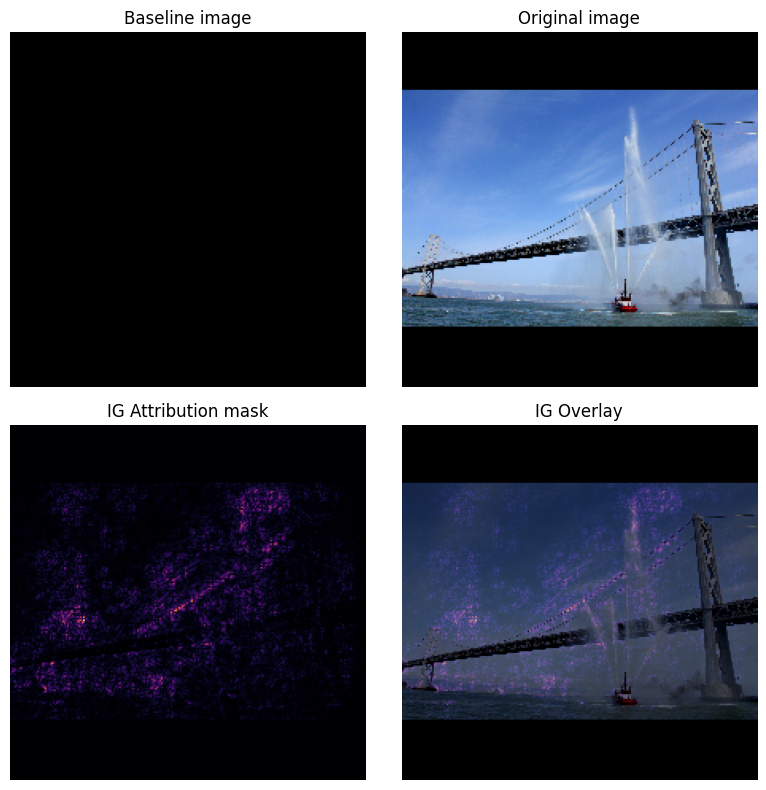

In [17]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],  baseline=baseline, target_class_idx=555, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)

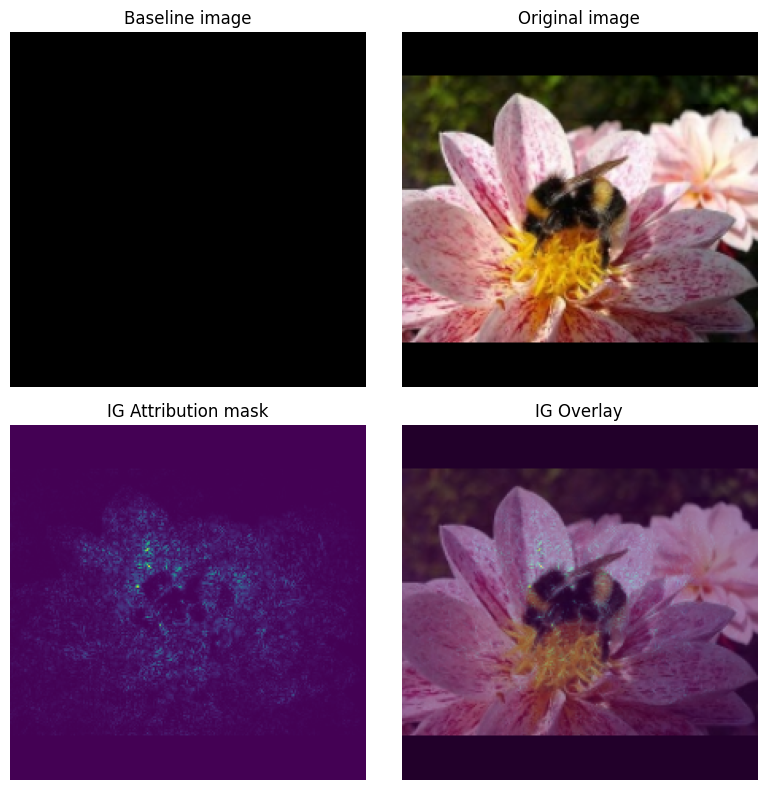

In [18]:
_ = plot_img_attributions(image=img_name_tensors['bee'], baseline=baseline, target_class_idx=309,  m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)

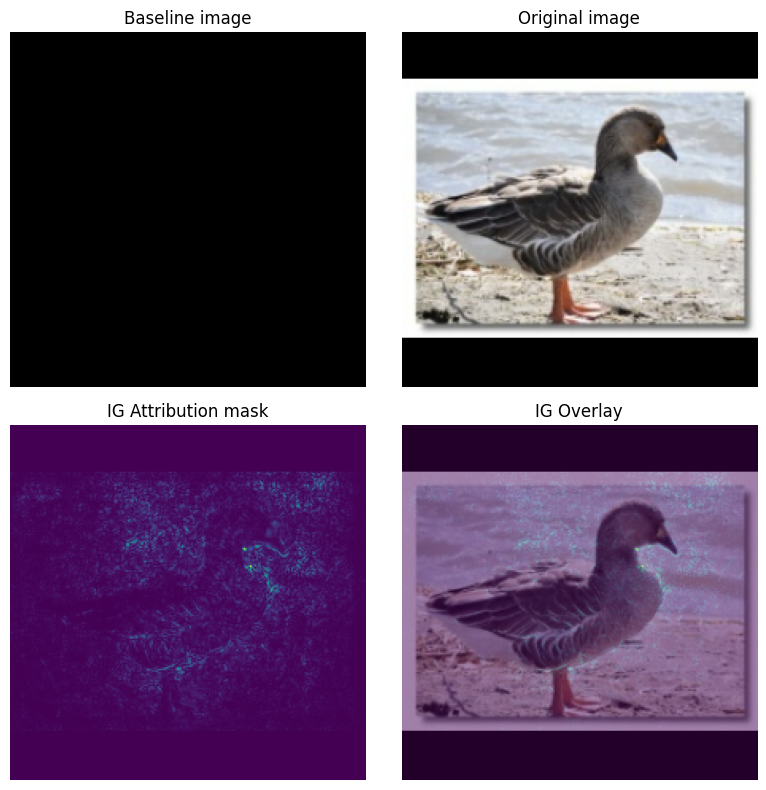

In [19]:
_ = plot_img_attributions(image=img_name_tensors['goose'], baseline=baseline, target_class_idx=99, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)

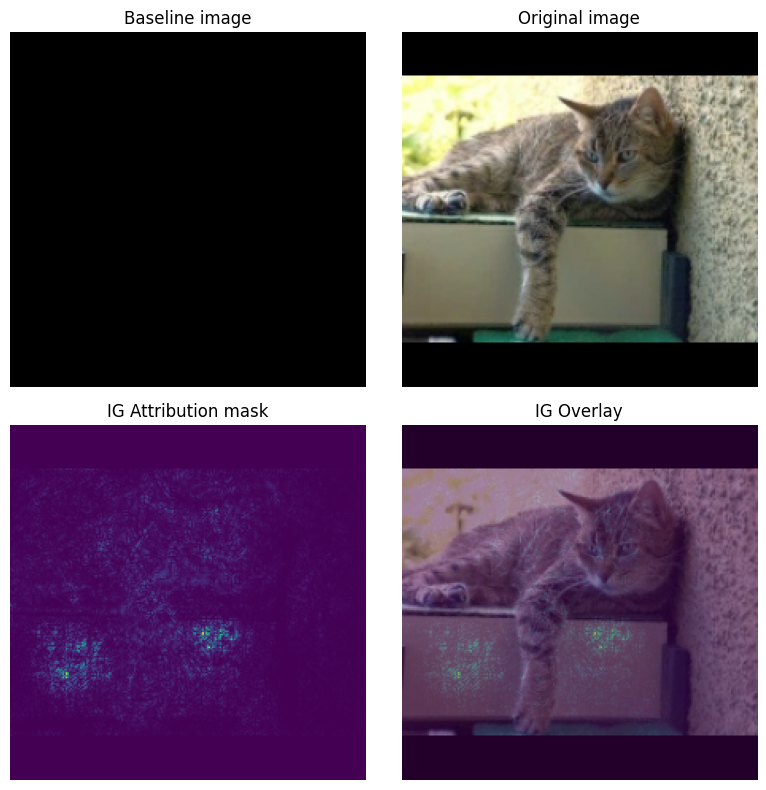

In [20]:
_ = plot_img_attributions(image=img_name_tensors['tiger cat'], baseline=baseline, target_class_idx=282, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)

#GradCAM

In [21]:
def compute_gradcam(model, img_tensor, class_idx, layer_name='conv5_block3_out'):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        probs = tf.nn.softmax(predictions, axis=-1)          # apply softmax here
        loss = probs[:, class_idx]                            # use softmax prob for the class
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()


def overlay_heatmap(image, heatmap, alpha=0.4, cmap='jet'):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = plt.cm.get_cmap(cmap)(heatmap_resized)[..., :3]
    superimposed = heatmap_colored * alpha + image / 255.0
    return np.clip(superimposed, 0, 1)


#Display Image

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipython-input-21-4199827461.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap_colored = plt.cm.get_cmap(cmap)(heatmap_resized)[..., :3]


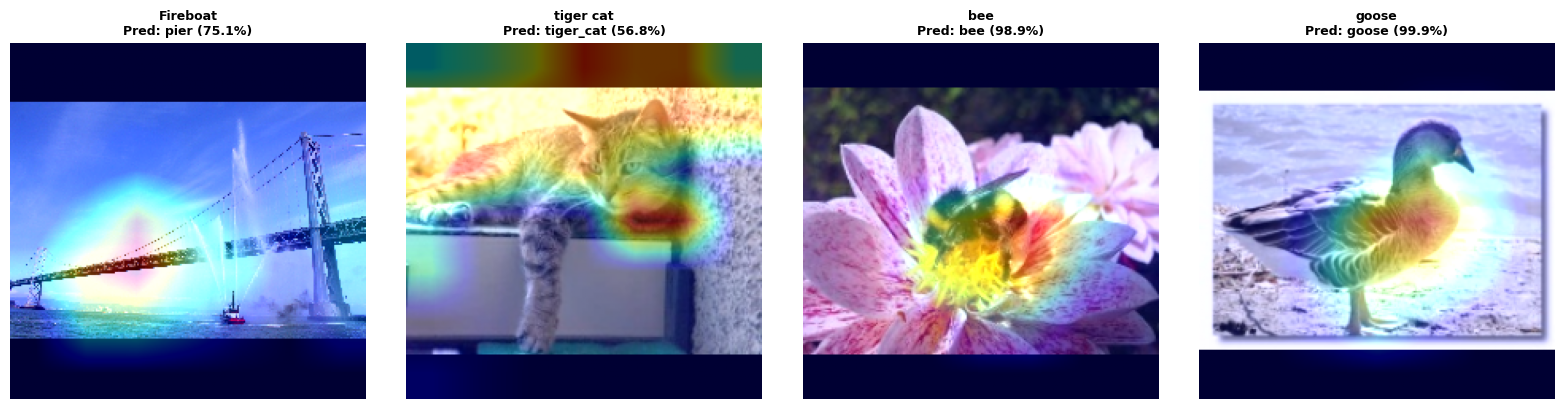

In [22]:
def display_image_grid_with_gradcam(img_name_tensors, pretrained_model):
    total_images = len(img_name_tensors)
    cols = 4
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for ax, (name, img_tensor) in zip(axes, img_name_tensors.items()):
        img = preprocess(img_tensor)
        img_batch = tf.expand_dims(img, 0)
        preds = pretrained_model.predict(img_batch, verbose=0)
        class_idx = np.argmax(preds[0])
        _, pred_label, confidence = tf.keras.applications.resnet_v2.decode_predictions(preds, top=1)[0][0]
        heatmap = compute_gradcam(pretrained_model, img_batch, class_idx)

        raw_img = img_tensor.numpy()
        if raw_img.max() <= 1.0:
            raw_img = (raw_img * 255).astype(np.uint8)
        overlay = overlay_heatmap(raw_img, heatmap)
        ax.imshow(overlay)
        ax.set_title(f"{name}\nPred: {pred_label} ({confidence:.1%})", fontweight='bold', fontsize=9)
        ax.axis('off')

    for i in range(len(img_name_tensors), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
display_image_grid_with_gradcam(img_name_tensors, model)
